In [44]:
# Project 3
# Oneza Vhora and Shalini Sundar

#Project Description: You are given a dataset which contains satellite images from Texas after Hurricane Harvey. There are damaged and non-damaged building images organized into respective folders.
#Your goal is to build multiple neural networks based on different architectures to classify images as containing buildings that are either damaged or not damaged. You will evaluate each of the networks you develop and produce and select the “best” network to “deploy”. Note that this is a binary classification problem, where the goal it to classify whether the structure in the image has damage or does not have damage.
#Part 1: (3 points) Data preprocessing and visualization
#You will need to perform data analysis and pre-processing to prepare the images for training. At a minimum, you should:
#Write code to load the data into Python data structures
#Investigate the datasets to determine basic attributes of the images
#Ensure data is split for training, validation and testing and perform any additional preprocessing (e.g., rescaling, normalization, etc.) so that it can be used for training/evaluation of the neural networks you will build in Part 2.
#Part 2: (10 points) Model design, training and evaluation
#You will explore different model architectures that we have seen in class, including:
#A dense (i.e., fully connected) ANN
#The Lenet-5 CNN architecture
#Alternate-Lenet-5 CNN architecture, described in the following paper (Table 1, Page 12 of the research paper https://arxiv.org/pdf/1807.01688.pdf, but note that the dataset is not the same as that analyzed in the paper.)
#You are free to experiment with different variants on all three architectures above. For example, for the fully connected ANN, feel free to experiment with different numbers of layers and perceptrons. Train and evaluate each model you build,and select the “best” performing model.
#Note that the input and output dimensions are fixed, as the inputs (images) and the outputs (labels) have been given. These have important implications for your architecture. Make sure you understand the constraints these impose before beginning to design and implement your networks. Failure to implement these correctly will lead to incorrect architectures and significant penalty on the project grade.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
from pathlib import Path
import random
import tensorflow as tf

# Define the base directory for the dataset
base_dir = 'coe379L-sp25/datasets/unit03/Project3'

# Verify the directory structure
damage_dir = os.path.join(base_dir, 'damage')
no_damage_dir = os.path.join(base_dir, 'no_damage')

# Make sure directories are clean before running the code
# Clear previous splits
shutil.rmtree('train', ignore_errors=True)
shutil.rmtree('test', ignore_errors=True)

# Create directories for training and testing. Ensure directories exist.
# Create directory structure
for category in ['damage', 'no_damage']:
    Path(f'train/{category}').mkdir(parents=True, exist_ok=True)
    Path(f'test/{category}').mkdir(parents=True, exist_ok=True)

# Split data into training and testing sets
# Filter image files
def filter_images_files(directory):
    return [f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Get all image files from damaged and undamaged directories
damage_files = filter_images_files(damage_dir)
no_damage_files = filter_images_files(no_damage_dir)

#split data
all_damage = [(os.path.join(damage_dir, f), 'damage') for f in damage_files]
all_no_damage = [(os.path.join(no_damage_dir, f), 'no_damage') for f in no_damage_files]
all_files = all_damage + all_no_damage
random.shuffle(all_files)

split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
test_files = all_files[split_idx:]

# copy files to train and test directories
# Copy to folders
for fpath, label in train_files:
    shutil.copy(fpath, os.path.join('train', label))
for fpath, label in test_files:
    shutil.copy(fpath, os.path.join('test', label))

# log the number of images in each directory
print(f"Total images: {(len(all_files))}")
print(f"Training images: {(len(train_files))}")
print(f"Testing images: {(len(test_files))}")    

Total images: 21322
Training images: 17057
Testing images: 4265


In [47]:
# Data Preprocessing and Augmentation: 
# Set input shape (Given is 128x128x3)
input_shape = (128, 128, 3)

# Create ImageDataGenerators for training and testing

# Used ChatGPT to help with the data augmentation and preprocessing
train_datagen = ImageDataGenerator(    
    rescale=1./255,  # Rescale pixel values to [0, 1] - normalization
    rotation_range=20,  # Random rotation in degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Random shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Fill missing pixels with nearest pixel value
    validation_split=0.2, # Reserve 20% of data for validation
    featurewise_center=True,  # Subtract the mean of the dataset
    featurewise_std_normalization=True,  # Divide by the std dev of the dataset
    )
test_datagen = ImageDataGenerator(rescale=1./255)

#Generators for train, validation and test data
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=input_shape[:2], # Resize images to match input shape
    batch_size=32,
    class_mode='binary', # Binary Classification
    subset='training' # Use training subset
)
validation_generator = train_datagen.flow_from_directory(
    'train',
    target_size=input_shape[:2],# Resize images to match input shape
    batch_size=32,
    class_mode='binary', # Binary Classification
    subset='validation' # Use validation subset
)
test_generator = test_datagen.flow_from_directory( 
    'test',
    target_size=input_shape[:2], # Resize images to match input shape
    batch_size=32,
    class_mode='binary' # Binary Classification
)

#print class names
print("Class names:", train_generator.class_indices)



Found 13646 images belonging to 2 classes.
Found 3411 images belonging to 2 classes.
Found 4265 images belonging to 2 classes.
Class names: {'damage': 0, 'no_damage': 1}


In [45]:
# Set image size
img_height, img_width = 128, 128
batch_size = 32

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# do the same for test
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    )

# Store class names BEFORE mapping
class_names = train_ds_raw.class_names
print("Class names:", class_names)

# Apply normalization (Rescale to 0–1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.
Found 21322 files belonging to 2 classes.
Class names: ['damage', 'no_damage']


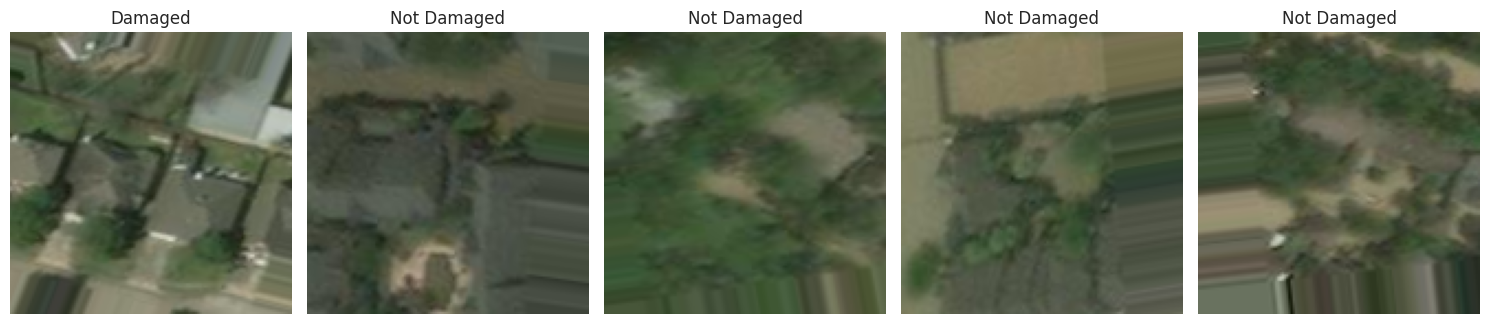

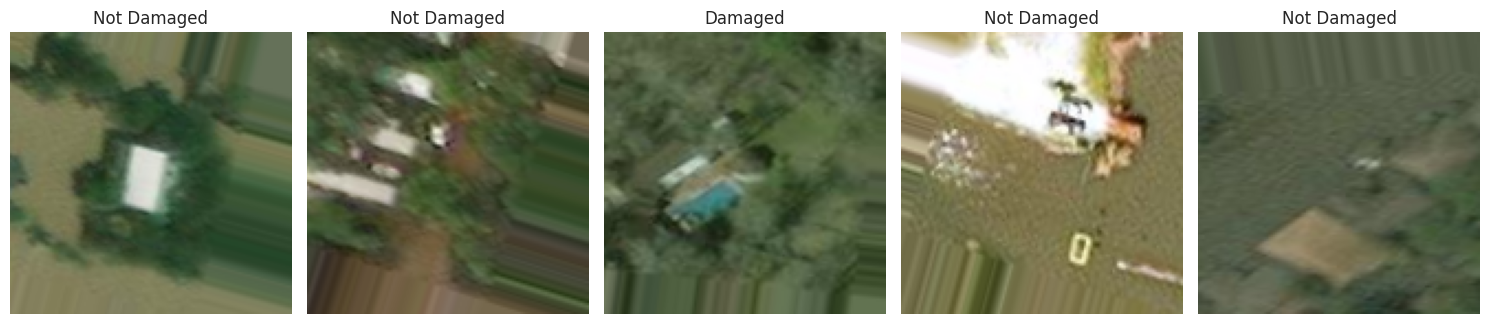

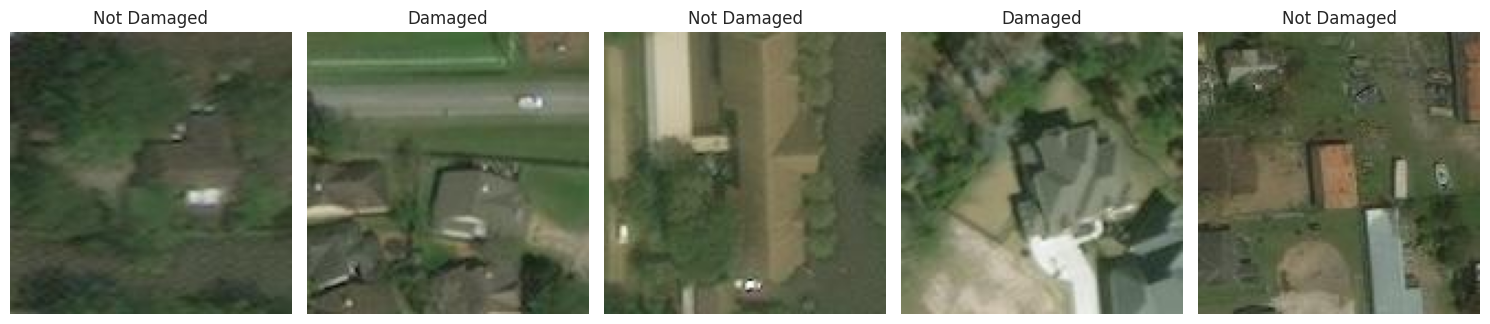

In [48]:
# Visualize some images from the training set
def visualize_images(generator, num_images=5):
    images, labels = next(generator)  # fetch a batch
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Damaged' if labels[i] == 1 else 'Not Damaged')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function after generator is defined
visualize_images(train_generator, num_images=5)
# Visualize some images from the validation set
visualize_images(validation_generator, num_images=5)
# Visualize some images from the test set
visualize_images(test_generator, num_images=5)



Epoch 1/20
427/427 [==============================] - ETA: 0s - loss: 1.5484 - accuracy: 0.6367

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


427/427 [==============================] - 84s 193ms/step - loss: 1.5484 - accuracy: 0.6367 - val_loss: 0.6387 - val_accuracy: 0.6640
Epoch 2/20
427/427 [==============================] - 84s 196ms/step - loss: 0.6404 - accuracy: 0.6638 - val_loss: 0.6386 - val_accuracy: 0.6640
Epoch 3/20
427/427 [==============================] - 82s 193ms/step - loss: 0.6459 - accuracy: 0.6635 - val_loss: 0.6384 - val_accuracy: 0.6640
Epoch 4/20
427/427 [==============================] - 82s 192ms/step - loss: 0.6412 - accuracy: 0.6636 - val_loss: 0.6383 - val_accuracy: 0.6640
Epoch 5/20
427/427 [==============================] - 78s 183ms/step - loss: 0.6405 - accuracy: 0.6642 - val_loss: 0.6384 - val_accuracy: 0.6640
Epoch 6/20
427/427 [==============================] - 79s 185ms/step - loss: 0.6406 - accuracy: 0.6638 - val_loss: 0.6384 - val_accuracy: 0.6640
Epoch 7/20
134/134 [==============================] - 2s 15ms/step - loss: 0.6366 - accuracy: 0.6666
ann Test accuracy: 0.6665884852409363
Ep

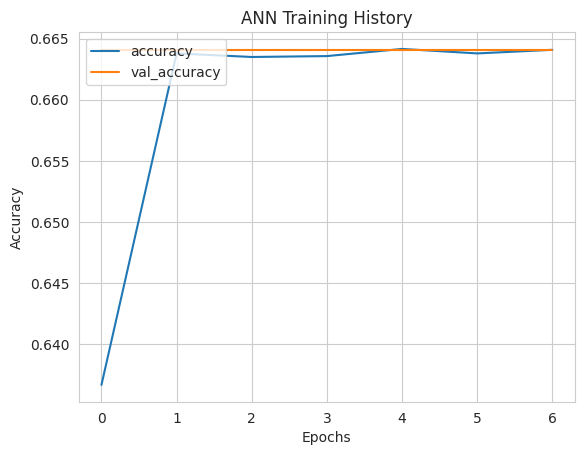

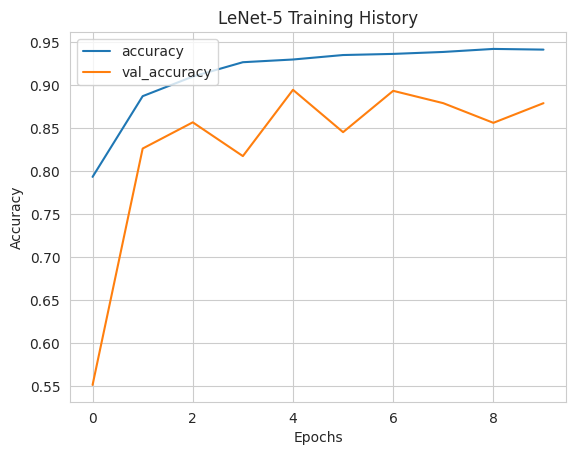

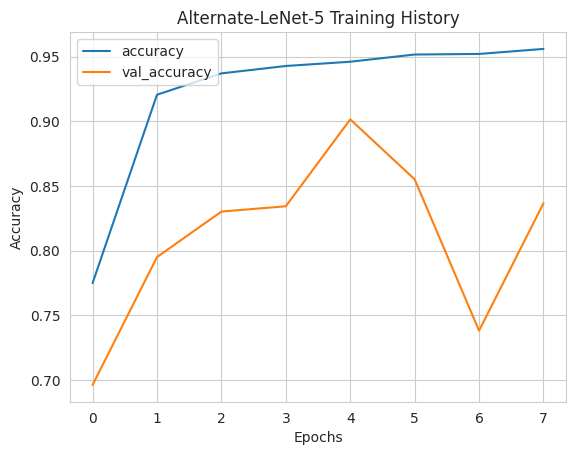

In [ ]:
# Model 1: Fully Connected ANN
from tensorflow.keras.layers import Flatten
def create_ann_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten images to 1D
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model 2: LeNet-5 CNN
def create_lenet5_model(input_shape):
    model = Sequential()
    model.add(Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))  # Conv layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling layer
    model.add(Conv2D(16, (5, 5), activation='relu'))  # Conv layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling layer
    model.add(Conv2D(120, (5, 5), activation='relu'))  # Conv layer 3
    model.add(Flatten())  # Flatten layer
    model.add(Dense(84, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model 3: Alternate-LeNet-5 CNN (as defined earlier)
def create_alternate_lenet5_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))  # Conv layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling layer
    model.add(Conv2D(64, (3, 3), activation='relu'))  # Conv layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling layer
    model.add(Conv2D(128, (3, 3), activation='relu'))  # Conv layer 3
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling layer
    model.add(Conv2D(128, (3, 3), activation='relu'))  # Conv layer 4
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling layer
    model.add(Flatten())  # Flatten layer
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(512, activation='relu'))  # Fully connected layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training and evaluation setup
def train_and_evaluate_model(model, model_name):
    # EarlyStopping and ModelCheckpoint for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5', save_best_only=True, monitor='val_loss', mode='min')

    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{model_name} Test accuracy: {test_acc}")
    return history

# Select a model and train
# Example: Train the ANN model
ann_model = create_ann_model(input_shape)
history_ann = train_and_evaluate_model(ann_model, "ann")

# Train the LeNet-5 model
lenet5_model = create_lenet5_model(input_shape)
history_lenet5 = train_and_evaluate_model(lenet5_model, "lenet5")

# Train the Alternate-LeNet-5 model
alternate_lenet5_model = create_alternate_lenet5_model(input_shape)
history_alternate_lenet5 = train_and_evaluate_model(alternate_lenet5_model, "alternate_lenet5")

# plot the training history for each model
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.title(f"{model_name} Training History")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

# Plot histories for all models
plot_history(history_ann, "ANN")
plot_history(history_lenet5, "LeNet-5")
plot_history(history_alternate_lenet5, "Alternate-LeNet-5")

In [62]:
# Evaluate on test set
def evaluate_model(model, model_name):
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{model_name} Test accuracy: {test_acc}")
    return test_acc

# Save the best model based on test accuracy
best_model = None
best_accuracy = 0.0
for model, name in [(ann_model, "ANN"), (lenet5_model, "LeNet-5"), (alternate_lenet5_model, "Alternate-LeNet-5")]:
    accuracy = evaluate_model(model, name)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

best_model.save("best_model.keras")

134/134 [==============================] - 2s 15ms/step - loss: 0.6366 - accuracy: 0.6666
ANN Test accuracy: 0.6665884852409363
134/134 [==============================] - 3s 24ms/step - loss: 0.1720 - accuracy: 0.9294
LeNet-5 Test accuracy: 0.9294255375862122
134/134 [==============================] - 6s 47ms/step - loss: 0.1871 - accuracy: 0.9259
Alternate-LeNet-5 Test accuracy: 0.9259085655212402


In [ ]:
# Best Model summary and file type check
best_model.summary()  # Print the summary of the best model
!file best_model.keras  # Check the file type of the saved model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 120)       48120     
                                                                 
 flatten_1 (Flatten)         (None, 75000)            